In [1]:
import os
import json
import imageio
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms

from lib import utils, tri_dvgo_multiscene, ray_utils

if torch.cuda.is_available():
    # torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Using /home/hydeng/.cache/torch_extensions as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/hydeng/.cache/torch_extensions/adam_upd_cuda/build.ninja...
Building extension module adam_upd_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module adam_upd_cuda...
Using /home/hydeng/.cache/torch_extensions as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/hydeng/.cache/torch_extensions/render_utils_cuda/build.ninja...
Building extension module render_utils_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module render_utils_cuda...


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
model_class = tri_dvgo_multiscene.DirectVoxGO

ckpt_path = 'logs/tri_dvgo_multiscene/nerf_synthetic/1res_conv_liif_scratch_no_cell_attn_lego_rnd_no_pos/fine_last.tar'
ckpt_path = 'logs/tri_dvgo_multiscene/nerf_synthetic/1res_conv_nl_block_liif_scratch_no_cell_attn_lego_rnd_no_pos/fine_last.tar'
ckpt_path = 'logs/sr_tri_dvgo_multiscene/nerf_synthetic/1conv_liif_no_cell_lego_cons_cosine_rnd/fine_last.tar'
ckpt_path = 'logs/sr_tri_dvgo_multiscene/nerf_synthetic/1conv_liif_no_cell_lego_rnd/fine_last.tar'

ckpt_path = 'logs/sr_tri_dvgo_multiscene/nerf_synthetic/1conv_liif_no_cell_lego_cons_cosine_rnd/fine_last.tar'

ckpt_path = 'logs/tri_dvgo_multiscene_v1/nerf_synthetic/1resconv_liif_d_o_lego/fine_last.tar'
ckpt_path = 'logs/tri_dvgo_multiscene_v1/nerf_synthetic/1resconv_liif_d_o_pos4_lego/fine_last.tar'
ckpt_path = 'logs/tri_dvgo_multiscene_v1/nerf_synthetic/1resconv_newrgb_liif_d_o_lego/fine_last.tar'

# ckpt_path = 'logs/tri_dvgo_multiscene/nerf_synthetic/3MLP_liif_pretrain_down4/fine_last.tar'
# ckpt_path = 'logs/tri_dvgo_multiscene/nerf_synthetic/MLP_liif_pretrain_down4/fine_last.tar'

In [4]:
model = utils.load_model(model_class, ckpt_path).to(device)

n_scene 1
initialized encoder networks
!!!!ResBlock!!!!!
!!!!Conv_Mapping!!!!!
initialized mapping networks

dvgo: xyz_min tensor([-0.7203, -1.2470, -0.6495], device='cuda:0')
dvgo: xyz_max tensor([0.7087, 1.2547, 1.0746], device='cuda:0')
dvgo: cosine_v1 False cosine_v2 False
dvgo: set density bias shift to -4.595119850134584

dvgo: voxel_size       4096000
dvgo: voxel_size       tensor(0.0115, device='cuda:0')
dvgo: world_size       tensor([124, 218, 150], device='cuda:0')
dvgo: voxel_size_base  tensor(0.0115, device='cuda:0')
dvgo: voxel_size_ratio tensor(1., device='cuda:0')

implicit voxel feat!!!
dvgo: dim0               66
dvgo: feat_unfold        False
dvgo: cell_decode        False
64
dvgo: mlp rgbnet(
  (head): Sequential(
    (0): Linear(in_features=60, out_features=128, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
   

In [5]:
def read_image(path):
    image = imageio.imread(path)
    image = (np.array(image) / 255.).astype(np.float32)
    if image.shape[-1] == 4:
        image = image[...,:3]*image[...,-1:] + (1.-image[...,-1:])
    return image

In [6]:
def read_poses(path, idxs):
    with open(path, 'r') as f:
        meta = json.load(f)
    poses = []
    for id in idxs:
        frame = meta['frames'][id]
        poses.append(np.array(frame['transform_matrix']))
    poses = np.stack(poses)
    return poses

In [7]:
imagedir = './data/nerf_synthetic/lego/train'
json_path = './data/nerf_synthetic/lego/transforms_train.json'
idxs = [34, 49, 63]  # [61, 95, 46] #

images = []
for id in idxs:
    path = os.path.join(imagedir, f'r_{id}.png')
    images.append(read_image(path))

images = np.stack(images)

poses = read_poses(json_path, idxs)


images = torch.FloatTensor(images)
poses = torch.FloatTensor(poses)

In [8]:
print(images.shape, poses.shape)

torch.Size([3, 800, 800, 3]) torch.Size([3, 4, 4])


In [9]:
HW = torch.tensor([[800, 800] for _ in range(3)])
with open(json_path, 'r') as f:
    meta = json.load(f)
    focal = .5 * 800 / np.tan(.5 * meta['camera_angle_x'])
K = np.array([
    [focal, 0, 0.5*800],
    [0, focal, 0.5*800],
    [0, 0, 1]
])

Ks = K[None].repeat(len(poses), axis=0)


In [10]:
rgb_tr, rays_o_tr, rays_d_tr, viewdirs_tr, imsz = ray_utils.get_training_rays(
    rgb_tr=images,
    train_poses=poses,
    HW=HW[:3], Ks=Ks[:3], ndc=False, inverse_y=False,
    flip_x=False, flip_y=False)

In [11]:
images = torch.cat([images, rays_o_tr, rays_d_tr], dim=-1)
images = images.permute(0, 3, 1, 2)
h, w = images.shape[-2:]
h, w = h // 4, w // 4
resize = transforms.Resize([h, w])
images = resize(images)
images = (images - 0.5) / 0.5

images = images.to(device)
poses = poses.to(device)

In [12]:
print(images.shape, poses.shape)

torch.Size([3, 9, 200, 200]) torch.Size([3, 4, 4])


In [13]:
# mapped_feats, feats, _, _, = model.encode_feat(images, poses, scene_id=0)
# feats = model.encode_feat_inference(images, poses, scene_id=0)

In [13]:
backbone_feats = model.backbone_encode(images)

In [14]:
print(backbone_feats.shape)

torch.Size([3, 64, 200, 200])


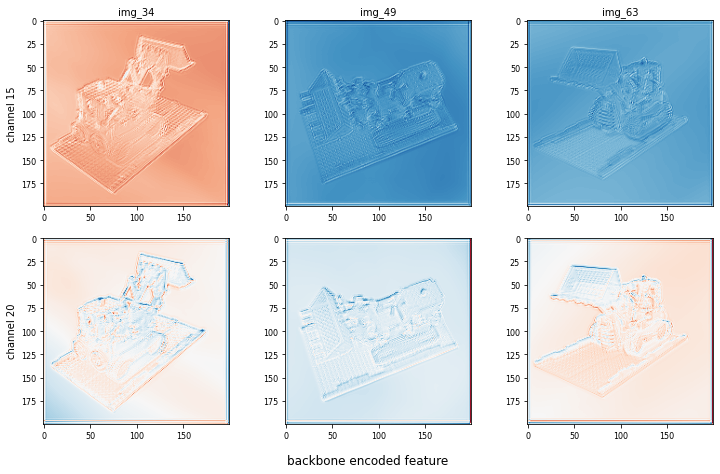

In [15]:
splits = [[0], [1], [2]]
channels = [15, 20]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.3, hspace=0)
vmin, vmax = 1e6, -1e6
for i, s in enumerate(splits):
    backbone_feats[s] = (backbone_feats[s] - backbone_feats[s].min()) / (backbone_feats[s].max() - backbone_feats[s].min())
    
    vmin = min(backbone_feats[s].min().item(), vmin)
    vmax = max(backbone_feats[s].max().item(), vmax)

for i, channel in enumerate(channels):
    for j, s in enumerate(splits):
        axes[i, j].imshow(backbone_feats[s][0][channel].detach().cpu().numpy(), cmap='RdBu')
        axes[i, j].xaxis.set_tick_params(labelsize=8)
        axes[i, j].yaxis.set_tick_params(labelsize=8)

rows = [f'channel {i}' for i in channels]
cols = [f'img_{i}' for i in [34, 49, 63]]
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=10)

for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=10)

plt.suptitle('backbone encoded feature', y=0.1)
plt.show()

torch.Size([3, 64, 200, 200])


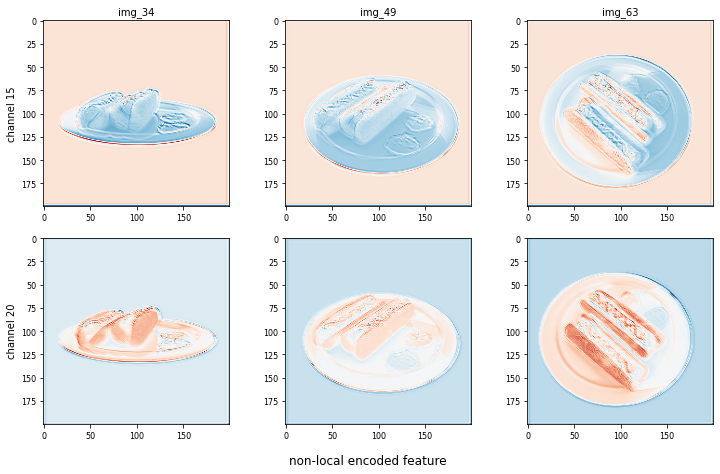

In [14]:
del feats
nl_feats = model.nl_density_attention(backbone_feats, scene_id=0, is_test=True)
print(nl_feats.shape)
splits = [[0],[1],[2]]
channels = [15, 20]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.3, hspace=0)
vmin, vmax = 1e6, -1e6
for i, s in enumerate(splits):
    nl_feats[s] = (nl_feats[s] - nl_feats[s].min()) / (nl_feats[s].max() - nl_feats[s].min())
    
    vmin = min(nl_feats[s].min().item(), vmin)
    vmax = max(nl_feats[s].max().item(), vmax)

for i, channel in enumerate(channels):
    for j, s in enumerate(splits):
        axes[i, j].imshow(nl_feats[s][0][channel].detach().cpu().numpy(), cmap='RdBu')
        axes[i, j].xaxis.set_tick_params(labelsize=8)
        axes[i, j].yaxis.set_tick_params(labelsize=8)

rows = [f'channel {i}' for i in channels]
cols = [f'img_{i}' for i in [34, 49, 63]]
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=10)

for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=10)

plt.suptitle('non-local encoded feature', y=0.1)
plt.show()

In [22]:
(nl_feats == backbone_feats).all()
del nl_feats

NameError: name 'nl_feats' is not defined

backbone only
mapping network


/home/hydeng/.conda/envs/nsvf/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


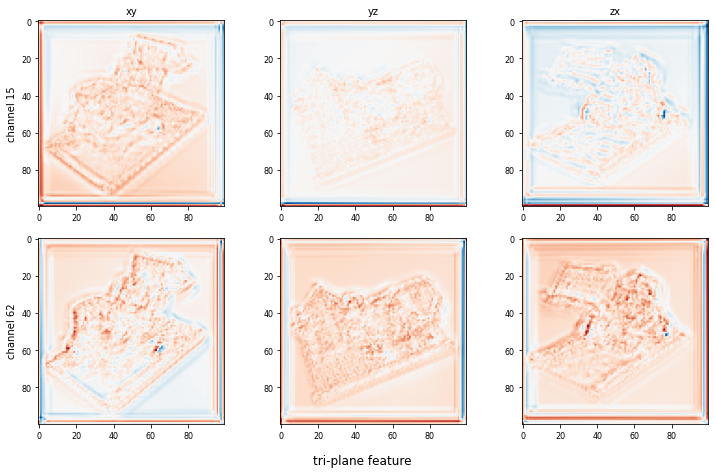

In [16]:
# del feats
feats = model.encode_feat_inference(images, poses, scene_id=0)
splits = ['xy', 'yz', 'zx']
channels = [15, 62]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.3, hspace=0)
# vmin, vmax = 1e6, -1e6
# for i, s in enumerate(splits):
#     feats[s] = (feats[s] - feats[s].min()) / (feats[s].max() - feats[s].min())
    
#     vmin = min(feats[s].min().item(), vmin)
#     vmax = max(feats[s].max().item(), vmax)

for i, channel in enumerate(channels):
    for j, s in enumerate(splits):
        axes[i, j].imshow(feats[s][0][channel].detach().cpu().numpy(), cmap='RdBu')
        axes[i, j].xaxis.set_tick_params(labelsize=8)
        axes[i, j].yaxis.set_tick_params(labelsize=8)

rows = [f'channel {i}' for i in channels]
cols = splits
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=10)

for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=10)

    
plt.suptitle('tri-plane feature',y=0.1)
plt.show()

In [17]:
print(torch.cosine_similarity(feats['xy'][0][:, 0, 0].unsqueeze(0), feats['yz'][0][:, 0, 0].unsqueeze(0)))

tensor([0.9766], device='cuda:0', grad_fn=<DivBackward0>)


In [18]:
print(feats['xy'][0][:, 0, 0].shape)

torch.Size([64])


In [19]:
sampling_feats = model.sampling_encode(backbone_feats, poses)
sampling_feats = sampling_feats.reshape(3, 3, 64, 200, 200)

In [20]:
print(backbone_feats.shape)

torch.Size([3, 64, 200, 200])


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

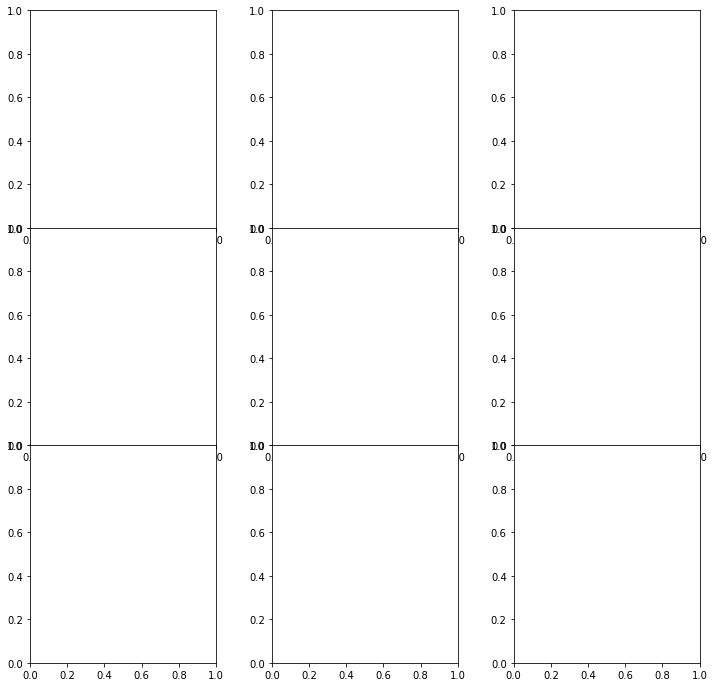

In [21]:
channels = 55
splits = [0, 1, 2]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.3, hspace=0)
vmin, vmax = 1e6, -1e6
for i in splits:
    for j in splits:
        sampling_feats[i, j] = (sampling_feats[i, j] - sampling_feats[i, j].min()) / (sampling_feats[i, j].max() - sampling_feats[i, j].min())
    
    vmin = min(sampling_feats[i, j].min().item(), vmin)
    vmax = max(sampling_feats[i, j].max().item(), vmax)

for i in splits:
    for j in splits:
        axes[i, j].imshow(sampling_feats[i, j][channel].detach().numpy(), cmap='RdBu')
        axes[i, j].xaxis.set_tick_params(labelsize=8)
        axes[i, j].yaxis.set_tick_params(labelsize=8)

rows = ['xy', 'yz', 'zx']
cols = [f'img_{i}' for i in [34, 49, 63]]
for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=10)

for ax, col in zip(axes[0], cols):
    ax.set_title(col, fontsize=10)

plt.suptitle('After sampling, encoded feature', y=0.1)
plt.show()

In [ ]:
print(model.density.shape)

In [ ]:
alpha = model.activate_density(model.density)
scene_id = 0
alpha_scene = alpha[scene_id]
print(alpha_scene.shape)

In [ ]:
def resize(feat):
    feat = F.interpolate(feat, (200, 200), mode='bilinear', align_corners=True)
    feat = feat.reshape(200, 200)
    return feat

In [ ]:
_, _, h, w = backbone_feats.shape
Nx, Ny, Nz = model.density.shape[-3:]

In [ ]:
alpha_xy = torch.cumsum(F.interpolate(alpha_scene, (h, w, Nz), mode='trilinear', align_corners=True), dim=-1)[..., -1].reshape(1, 1, h, w)
print(alpha_xy.shape)

In [ ]:
plt.imshow(alpha_xy[0, 0].detach().cpu().numpy(), cmap='RdBu')

In [ ]:
alpha_yz = torch.cumsum(F.interpolate(alpha_scene, (Nx, h, w), mode='trilinear', align_corners=True), dim=-3)[:, :, -1, :, :].reshape(1, 1, h, w)

In [ ]:
plt.imshow(alpha_yz[0, 0].detach().cpu().numpy(), cmap='RdBu')

In [ ]:
alpha_zx = torch.cumsum(F.interpolate(alpha_scene, (h, Ny, w), mode='trilinear', align_corners=True), dim=-2)[:, :, :, -1, :].reshape(1, 1, h, w)
plt.imshow(alpha_zx[0, 0].detach().cpu().numpy(), cmap='RdBu')